# Provisiones

## Introducción



## 1. Importación de Librerías

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

## 2. Configuración del Entorno

In [3]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [4]:
df_total=pd.read_parquet(f'{data_dir}complete_data.parquet')

## 4. Preparación de los Datos

In [6]:
df_total.fecha_corte.max()

Timestamp('2022-05-28 00:00:00')

In [6]:
# cartera activa
df_cartera_=df_total[df_total['fecha_corte']=='2022-05-28'].copy()

## 5. Provisiones 

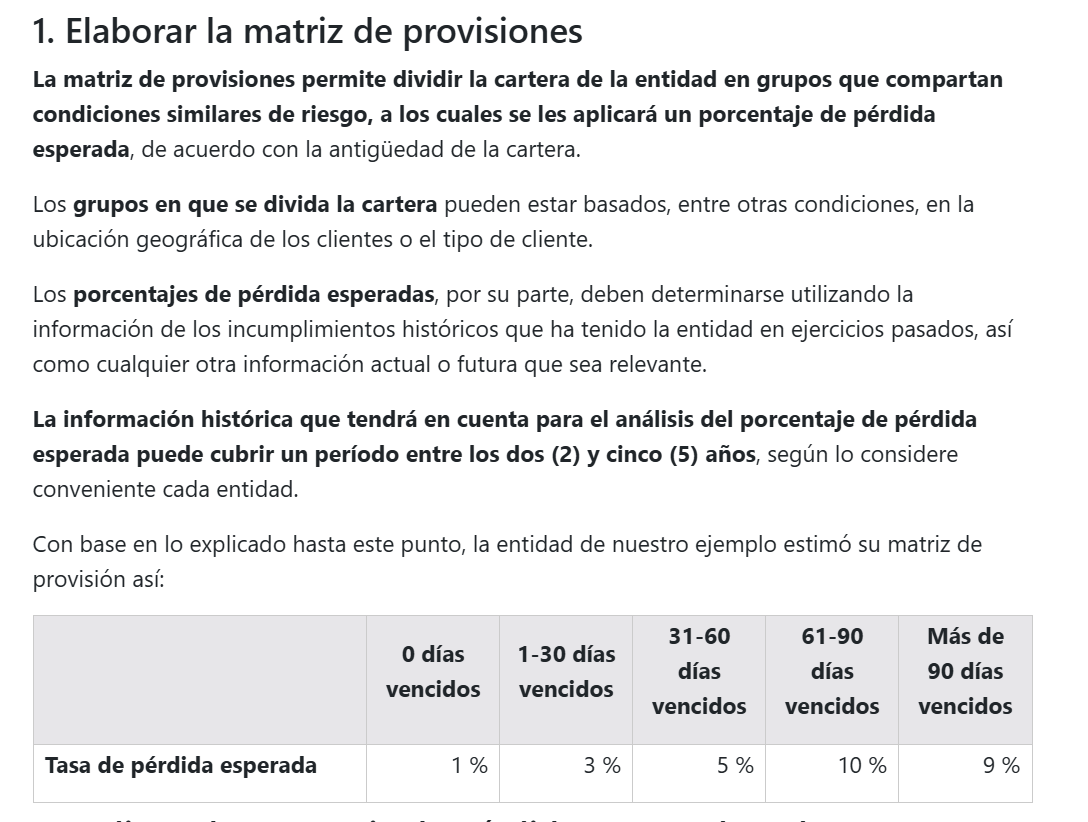

In [7]:
## esta es una de las tecnicas sencillas que se utiliza para provicionar 


df_cartera_['LGD']=np.where(df_cartera_['expirationDays']<=0,0.01,
np.where(df_cartera_['expirationDays']<=30,0.03,
np.where(df_cartera_['expirationDays']<=60,0.05,
np.where(df_cartera_['expirationDays']<=90,0.1,0.09
))))

In [8]:
df_cartera_.head(2)

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays,LGD
211980,3668,2020-12-12,2021-04-16,NaT,Consumo Basico,4,18958622.0,2022-05-28,125,407.0,0.09
211981,3670,2020-12-12,2021-05-06,NaT,Consumo Basico,4,22009343.0,2022-05-28,145,387.0,0.09


In [9]:
## con este calculo podemos tener una base de las perdidas 
# otra formual es pd*ead*lgd , donde pd es la probabilidad de default


df_cartera_['PE']=df_cartera_['LGD']*df_cartera_['amountFinanced']

In [10]:
import sys
import os
import joblib
sys.path.append(os.path.abspath("../src"))

# Importar el archivo model.py como cp
import model as cp

model_rl=joblib.load(models_dir+'modelo_entrenado_RL.pkl')
model_ml=joblib.load(models_dir+'modelo_entrenado_ML.pkl')

In [11]:
df_cartera_['fecha_observacion']=pd.to_datetime(df_cartera_['fecha_corte'])

In [12]:
var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

df_cartera_['score_rl'] = (model_rl.predict_proba(df_cartera_[var_primarias])[:,0]*1000).round().astype(int)
df_cartera_['score_ml'] = (model_ml.predict_proba(df_cartera_[var_primarias])[:,0]*1000).round().astype(int)

## Analisis proviciones

In [13]:
def decisiones_rl(df,score='score'):
    df['decisiones']=np.where(df[score]>976,'1 - AAA',
                     np.where(df[score]>867,'2 - AA', 
                    np.where(df[score]>708,'3 - A',  
                    np.where(df[score]>413,'4 - Analiza','5 - Rechaza'))))
    
    return df['decisiones']


def decisiones_ml(df,score='score'):
    df['decisiones']=np.where(df[score]>965,'1 - AAA',
                     np.where(df[score]>931,'2 - AA', 
                    np.where(df[score]>856,'3 - A',  
                    np.where(df[score]>771,'4 - Analiza','5 - Rechaza'))))
    
    return df['decisiones']

In [14]:
df_cartera_['decisiones_rl'] = decisiones_rl(df_cartera_,score='score_rl')
df_cartera_['decisiones_ml'] = decisiones_ml(df_cartera_,score='score_ml')

In [20]:
pd.options.display.float_format = '{:.3f}'.format
df_pe_rl=df_cartera_.groupby(['decisiones_rl']).agg(
    ead=('amountFinanced','sum'),
    PE=('PE','sum'),
)

df_pe_rl["PE/EAD"]=df_pe_rl["PE"]/df_pe_rl["ead"]
df_pe_rl["%pe"]=df_pe_rl["PE"]/df_pe_rl["PE"].sum()
df_pe_rl

,ead,PE,PE/EAD,%pe
decisiones_rl,,,,
1 - AAA,44278001613.000,2503653613.920,0.057,0.610
2 - AA,10622243509.000,810451537.050,0.076,0.197
3 - A,1696928488.000,121596395.520,0.072,0.030
4 - Analiza,826700492.000,59653158.490,0.072,0.015
5 - Rechaza,8410081217.000,610639346.610,0.073,0.149


In [19]:
df_pe_ml=df_cartera_.groupby(['decisiones_ml']).agg(
    ead=('amountFinanced','sum'),
    PE=('PE','sum'),
)

df_pe_ml["PE/EAD"]=df_pe_ml["PE"]/df_pe_ml["ead"]
df_pe_ml["%pe"]=df_pe_ml["PE"]/df_pe_ml["PE"].sum()
df_pe_ml

,ead,PE,PE/EAD,%pe
decisiones_ml,,,,
1 - AAA,47969349992.000,2889815698.990,0.060,0.704
2 - AA,5658720033.000,327556227.960,0.058,0.080
3 - A,3560094736.000,253035545.600,0.071,0.062
4 - Analiza,2334831471.000,164151962.340,0.070,0.040
5 - Rechaza,6310959087.000,471434616.700,0.075,0.115


In [ ]:
# si bin el pe/ead es similar por segmento se observa que la distribucion de la %PE es diferente , con modelo RL se proviciona mas para el rechaza que el de ML

In [34]:
df_cartera_["PE"].sum()

4105994051.59

In [ ]:
# provisiones totales 4105994051.59

### Conclusiones: Cálculo de Provisiones

1. **Método de cálculo utilizado:**
   - Se empleó una técnica sencilla para el cálculo de provisiones, que sirve como una base inicial para estimar las pérdidas esperadas.
   - Otra fórmula estándar utilizada en la industria es **`PD * EAD * LGD`**, donde:
     - **PD (Probability of Default):** Probabilidad de default.
     - **EAD (Exposure at Default):** Exposición en el momento del default.
     - **LGD (Loss Given Default):** Porcentaje de la exposición que se espera perder.

2. **Análisis de provisiones por modelo:**
   - Al comparar las provisiones calculadas por las decisiones del modelo de **Machine Learning (ML)** y el modelo de **Regresión Logística (RL)**, se observan diferencias notables:
     - **PE/EAD por segmento:** Similar entre ambos modelos, lo que indica que ambos logran estimaciones consistentes del porcentaje de pérdida esperada respecto a la exposición.
     - **Distribución del %PE:** Diferente entre los modelos. El modelo de **Regresión Logística (RL)** asigna una mayor provisión al segmento de "rechazar" en comparación con el modelo de ML.

3. **Provisiones totales:**
   - El total de provisiones calculado es **4,105,994,051.59**, una cifra que refleja la magnitud de las pérdidas esperadas en la cartera analizada.


Este análisis proporciona una base sólida para estimar las pérdidas esperadas y resalta las diferencias clave entre los enfoques basados en ML y RL. Estas observaciones pueden guiar decisiones futuras sobre la estrategia de provisiones y refinamientos del modelo.